In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from safetensors.torch import save_model, load_model


In [2]:
batch_size = 256
figsize = 16

In [3]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CelebA(
    root='./data',  # Directory where the dataset will be saved
    split='train',  # Choose 'train', 'valid', or 'test'
    target_type='attr',  # Attributes to download
    transform=transform,  # Transform to apply to images
    download=True  # Download the dataset if not already present
)

test_dataset = torchvision.datasets.CelebA(
    root='./data',  # Directory where the dataset will be saved
    split='test',  # Choose 'train', 'valid', or 'test'
    target_type='attr',  # Attributes to download
    transform=transform,  # Transform to apply to images
    download=True  # Download the dataset if not already present
)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


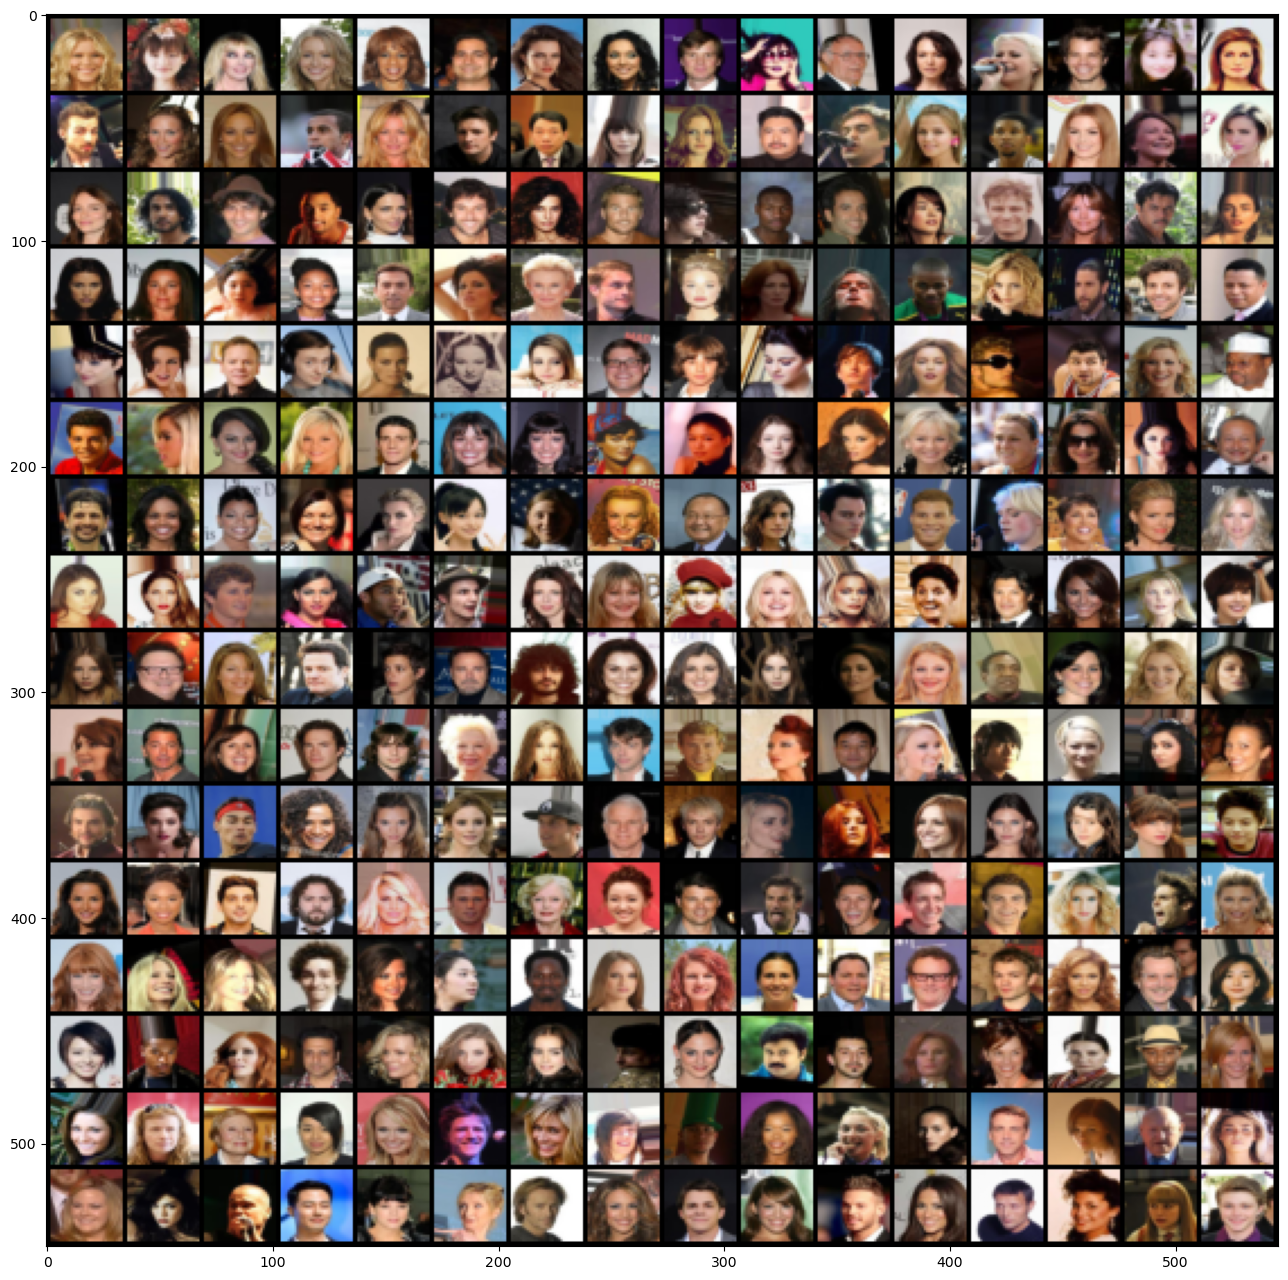

In [4]:
def imshow(img):
    plt.figure(figsize=(figsize,figsize))
    plt.imshow(img.cpu().permute(1, 2, 0).numpy())
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images, nrow=16))

In [5]:
images[0].shape

torch.Size([3, 32, 32])

In [6]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, 2, 1)
        self.bn1 = nn.BatchNorm2d(128)
        self.leaky_relu1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(128, 128, 3, 2, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.leaky_relu2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(128, 128, 3, 2, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.leaky_relu3 = nn.LeakyReLU()
        
        self.conv4 = nn.Conv2d(128, 128, 3, 2, 1)
        self.bn4 = nn.BatchNorm2d(128)
        self.leaky_relu4 = nn.LeakyReLU()
        
        self.flatten = nn.Flatten()
        self.mean = nn.Linear(512, 200)
        self.logvar = nn.Linear(512, 200)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leaky_relu3(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.leaky_relu4(x)
        
        x = self.flatten(x)
        mean = self.mean(x)
        logvar = self.logvar(x)
        z = self.reparameterize(mean, logvar)
        return z, mean, logvar


In [7]:
encoder = Encoder().cuda()
summary(encoder, (batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [256, 200]                --
├─Conv2d: 1-1                            [256, 128, 16, 16]        3,584
├─BatchNorm2d: 1-2                       [256, 128, 16, 16]        256
├─LeakyReLU: 1-3                         [256, 128, 16, 16]        --
├─Conv2d: 1-4                            [256, 128, 8, 8]          147,584
├─BatchNorm2d: 1-5                       [256, 128, 8, 8]          256
├─LeakyReLU: 1-6                         [256, 128, 8, 8]          --
├─Conv2d: 1-7                            [256, 128, 4, 4]          147,584
├─BatchNorm2d: 1-8                       [256, 128, 4, 4]          256
├─LeakyReLU: 1-9                         [256, 128, 4, 4]          --
├─Conv2d: 1-10                           [256, 128, 2, 2]          147,584
├─BatchNorm2d: 1-11                      [256, 128, 2, 2]          256
├─LeakyReLU: 1-12                        [256, 128, 2, 2]      

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()        
        self.fc = nn.Linear(200, 512)
        self.bn = nn.BatchNorm1d(512)
        self.leaky_relu = nn.LeakyReLU()
        
        self.unflatten = nn.Unflatten(1, (128 , 2 , 2))

        self.convt1 = nn.ConvTranspose2d(128, 128, 3, 2, 1, 1)
        self.bn1 = nn.BatchNorm2d(128)
        self.leaky_relu1 = nn.LeakyReLU()

        self.convt2 = nn.ConvTranspose2d(128, 128, 3, 2, 1, 1)
        self.bn2 = nn.BatchNorm2d(128)
        self.leaky_relu2 = nn.LeakyReLU()

        self.convt3 = nn.ConvTranspose2d(128, 128, 3, 2, 1, 1)
        self.bn3 = nn.BatchNorm2d(128)
        self.leaky_relu3 = nn.LeakyReLU()

        self.convt4 = nn.ConvTranspose2d(128, 128, 3, 2, 1, 1)
        self.bn4 = nn.BatchNorm2d(128)
        self.leaky_relu4 = nn.LeakyReLU()

        self.convt5 = nn.ConvTranspose2d(128, 3, 3, 1, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc(x)
        x = self.bn(x)
        x = self.leaky_relu(x)

        x = self.unflatten(x)
        
        x = self.convt1(x)
        x = self.bn1(x)
        x = self.leaky_relu1(x)

        x = self.convt2(x)
        x = self.bn2(x)
        x = self.leaky_relu2(x)
        
        x = self.convt3(x)
        x = self.bn3(x)
        x = self.leaky_relu3(x)

        x = self.convt4(x)
        x = self.bn4(x)
        x = self.leaky_relu4(x)

        x = self.convt5(x)
        x = self.sigmoid(x)
        return x

In [9]:
decoder = Decoder().cuda()
summary(decoder, (batch_size, 200))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [256, 3, 32, 32]          --
├─Linear: 1-1                            [256, 512]                102,912
├─BatchNorm1d: 1-2                       [256, 512]                1,024
├─LeakyReLU: 1-3                         [256, 512]                --
├─Unflatten: 1-4                         [256, 128, 2, 2]          --
├─ConvTranspose2d: 1-5                   [256, 128, 4, 4]          147,584
├─BatchNorm2d: 1-6                       [256, 128, 4, 4]          256
├─LeakyReLU: 1-7                         [256, 128, 4, 4]          --
├─ConvTranspose2d: 1-8                   [256, 128, 8, 8]          147,584
├─BatchNorm2d: 1-9                       [256, 128, 8, 8]          256
├─LeakyReLU: 1-10                        [256, 128, 8, 8]          --
├─ConvTranspose2d: 1-11                  [256, 128, 16, 16]        147,584
├─BatchNorm2d: 1-12                      [256, 128, 16, 16] 

In [10]:
class Vae(nn.Module):
    def __init__(self):
        super(Vae, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z, mean, logvar = self.encoder(x)
        x = self.decoder(z)
        return x, z, mean, logvar


In [11]:
model = Vae().cuda()
summary(model, (batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Vae                                      [256, 3, 32, 32]          --
├─Encoder: 1-1                           [256, 200]                --
│    └─Conv2d: 2-1                       [256, 128, 16, 16]        3,584
│    └─BatchNorm2d: 2-2                  [256, 128, 16, 16]        256
│    └─LeakyReLU: 2-3                    [256, 128, 16, 16]        --
│    └─Conv2d: 2-4                       [256, 128, 8, 8]          147,584
│    └─BatchNorm2d: 2-5                  [256, 128, 8, 8]          256
│    └─LeakyReLU: 2-6                    [256, 128, 8, 8]          --
│    └─Conv2d: 2-7                       [256, 128, 4, 4]          147,584
│    └─BatchNorm2d: 2-8                  [256, 128, 4, 4]          256
│    └─LeakyReLU: 2-9                    [256, 128, 4, 4]          --
│    └─Conv2d: 2-10                      [256, 128, 2, 2]          147,584
│    └─BatchNorm2d: 2-11                 [256, 128, 2, 2]       

In [12]:
def loss_function(y, x, mean, logvar):
    bce_loss = F.binary_cross_entropy(y, x, reduction='sum')
    
    # KL divergence
    kld_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    
    return bce_loss + kld_loss, bce_loss, kld_loss

In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
writer = SummaryWriter()

In [14]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    batch_idx = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.cuda(), labels.cuda()    
        y, z, mean, logvar = model(imgs)
        total_loss, bce_loss, kld_loss = loss_function(y, imgs, mean, logvar)

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        train_loss += total_loss.item()
        writer.add_scalar('Total Loss', total_loss.item(), batch_idx)
        writer.add_scalar('BCE Loss', bce_loss.item(), batch_idx)
        writer.add_scalar('KLD Loss', kld_loss.item(), batch_idx)
        batch_idx += 1

    model.eval()
    with torch.no_grad():
        sample = torch.randn(64, 200).cuda()
        generated_images = model.decoder(sample)
        grid = torchvision.utils.make_grid(generated_images, nrow=8)
        writer.add_image('VAE Generated Images', grid, epoch)
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
writer.close()

Epoch [1/10], Loss: 1787.5018
Epoch [2/10], Loss: 1663.7187
Epoch [3/10], Loss: 1651.0164
Epoch [4/10], Loss: 1645.8195
Epoch [5/10], Loss: 1642.6741
Epoch [6/10], Loss: 1640.4190
Epoch [7/10], Loss: 1639.0182
Epoch [8/10], Loss: 1638.2755
Epoch [9/10], Loss: 1636.9038
Epoch [10/10], Loss: 1636.0521


In [15]:
save_model(model, "data/vae_faces.safetensors")

In [16]:
model = Vae().cuda()

In [17]:
load_model(model, "data/vae_faces.safetensors")

(set(), [])

In [18]:
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
test_x, test_label = next(iter(test_loader))
test_x = test_x.cuda()
with torch.no_grad():
    test_y, z, mean, logvar = model(test_x)

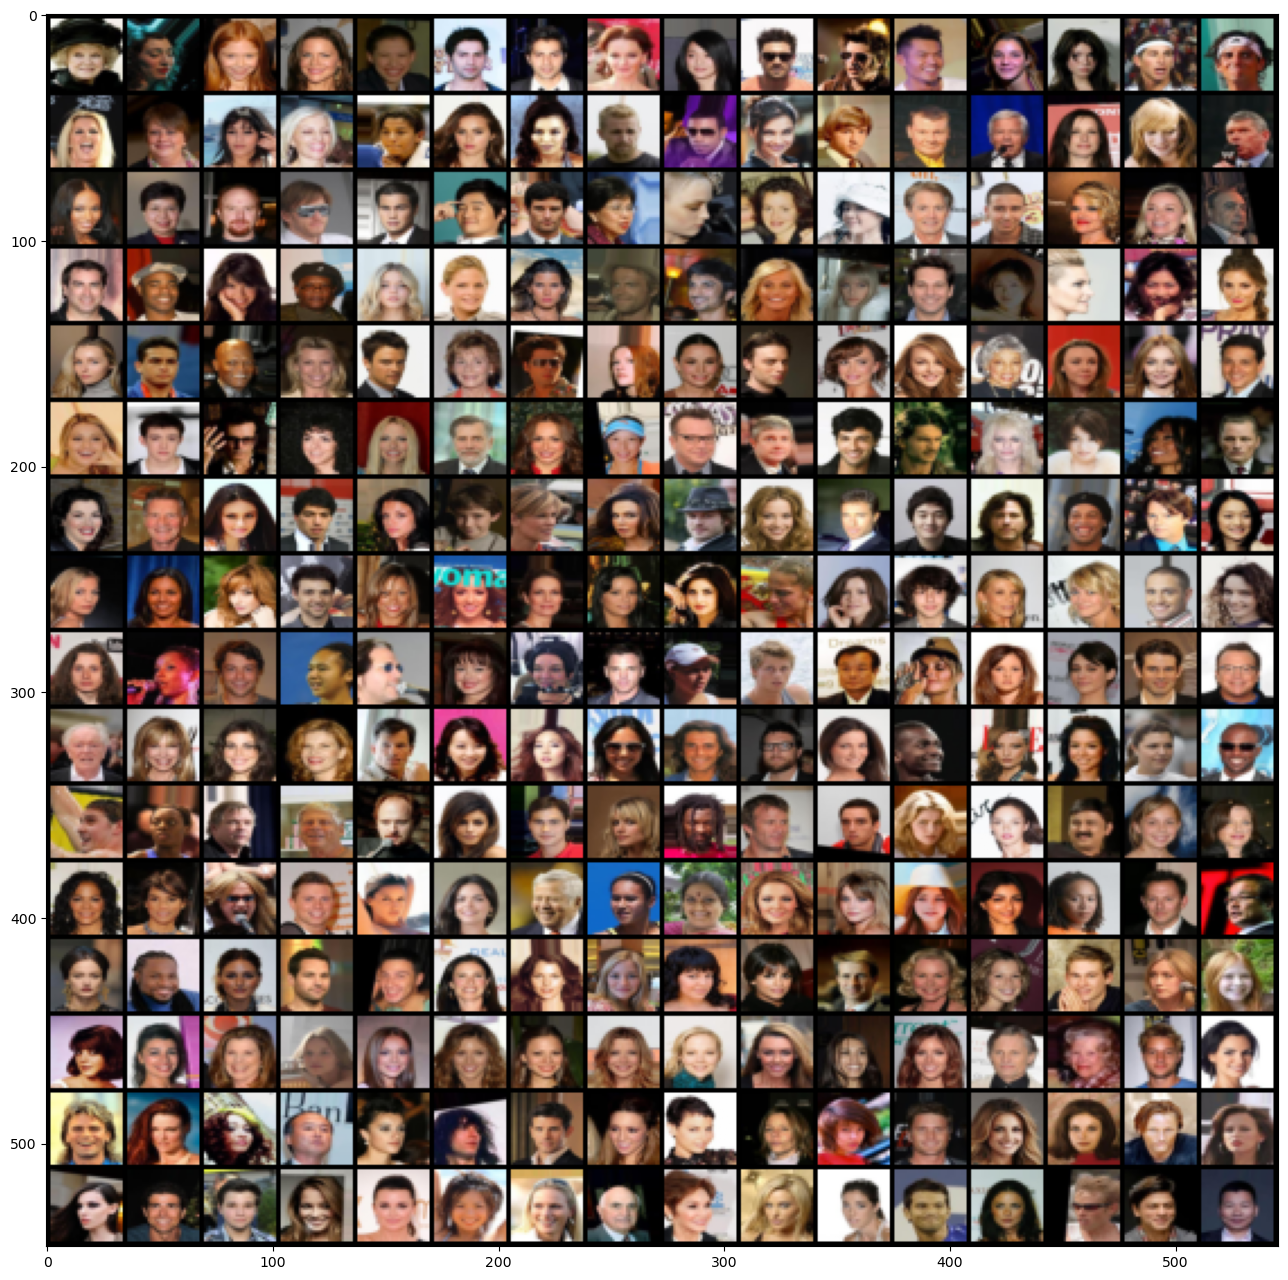

In [21]:
imshow(torchvision.utils.make_grid(test_x, nrow=16))

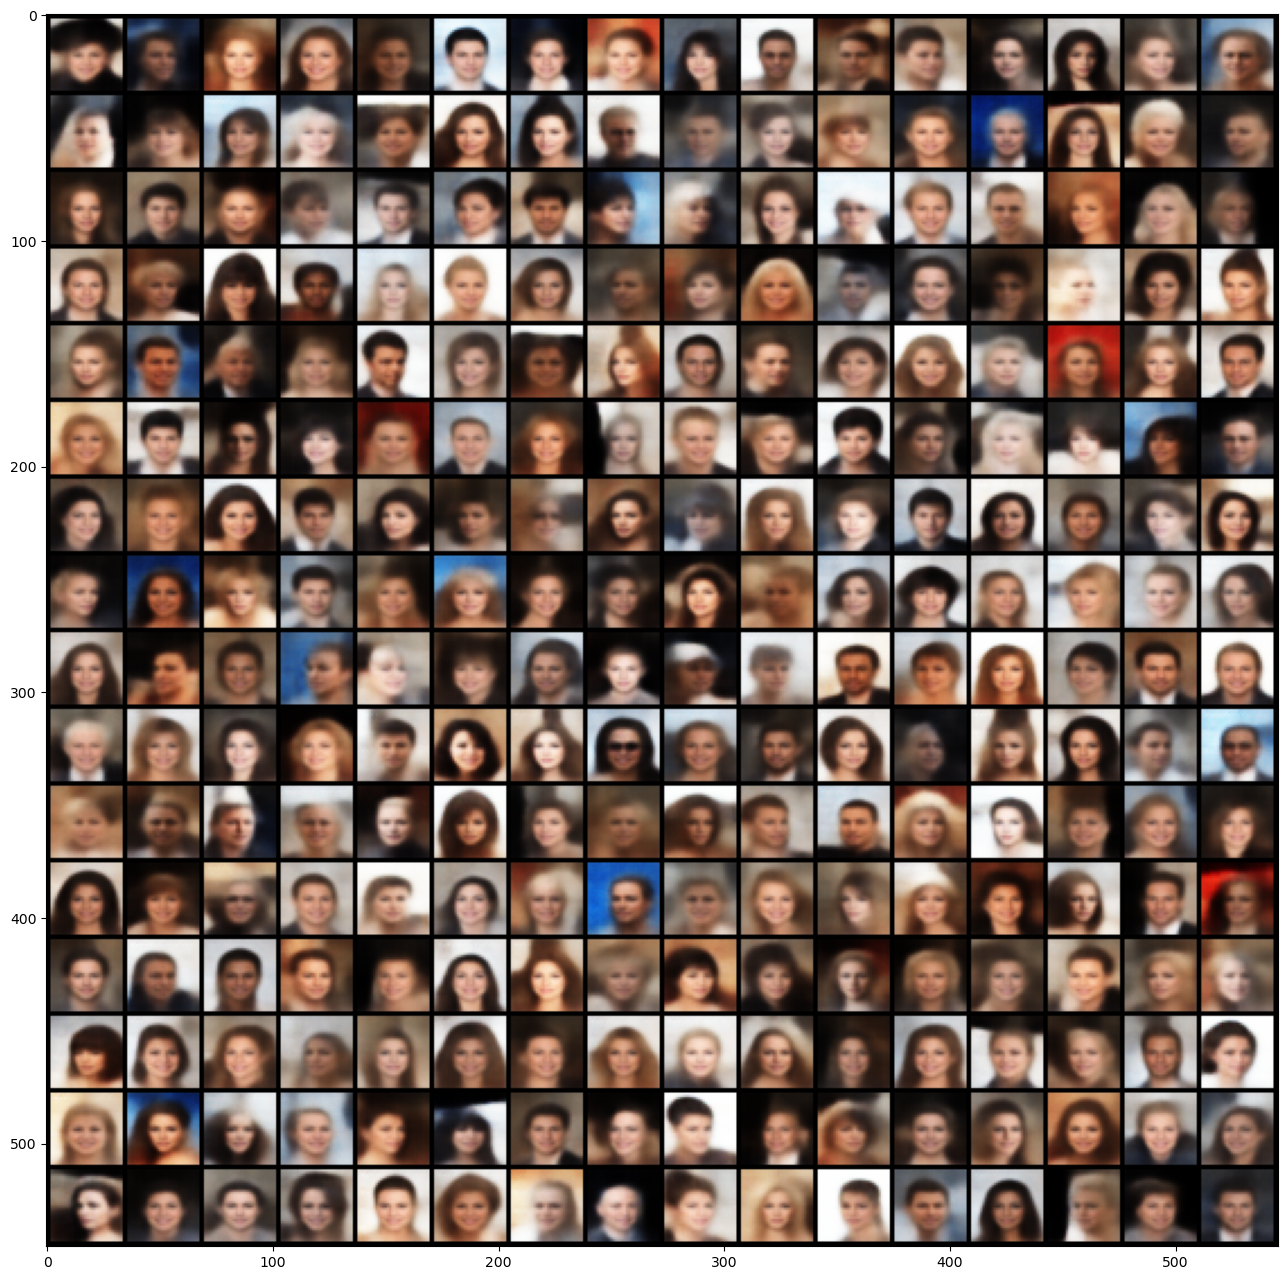

In [20]:
imshow(torchvision.utils.make_grid(test_y, nrow=16))

In [22]:
with torch.no_grad():
    z, mean, logvar = model.encoder(test_x)

In [53]:
z = z.cpu()

In [54]:
z[:, 1].shape

torch.Size([256])

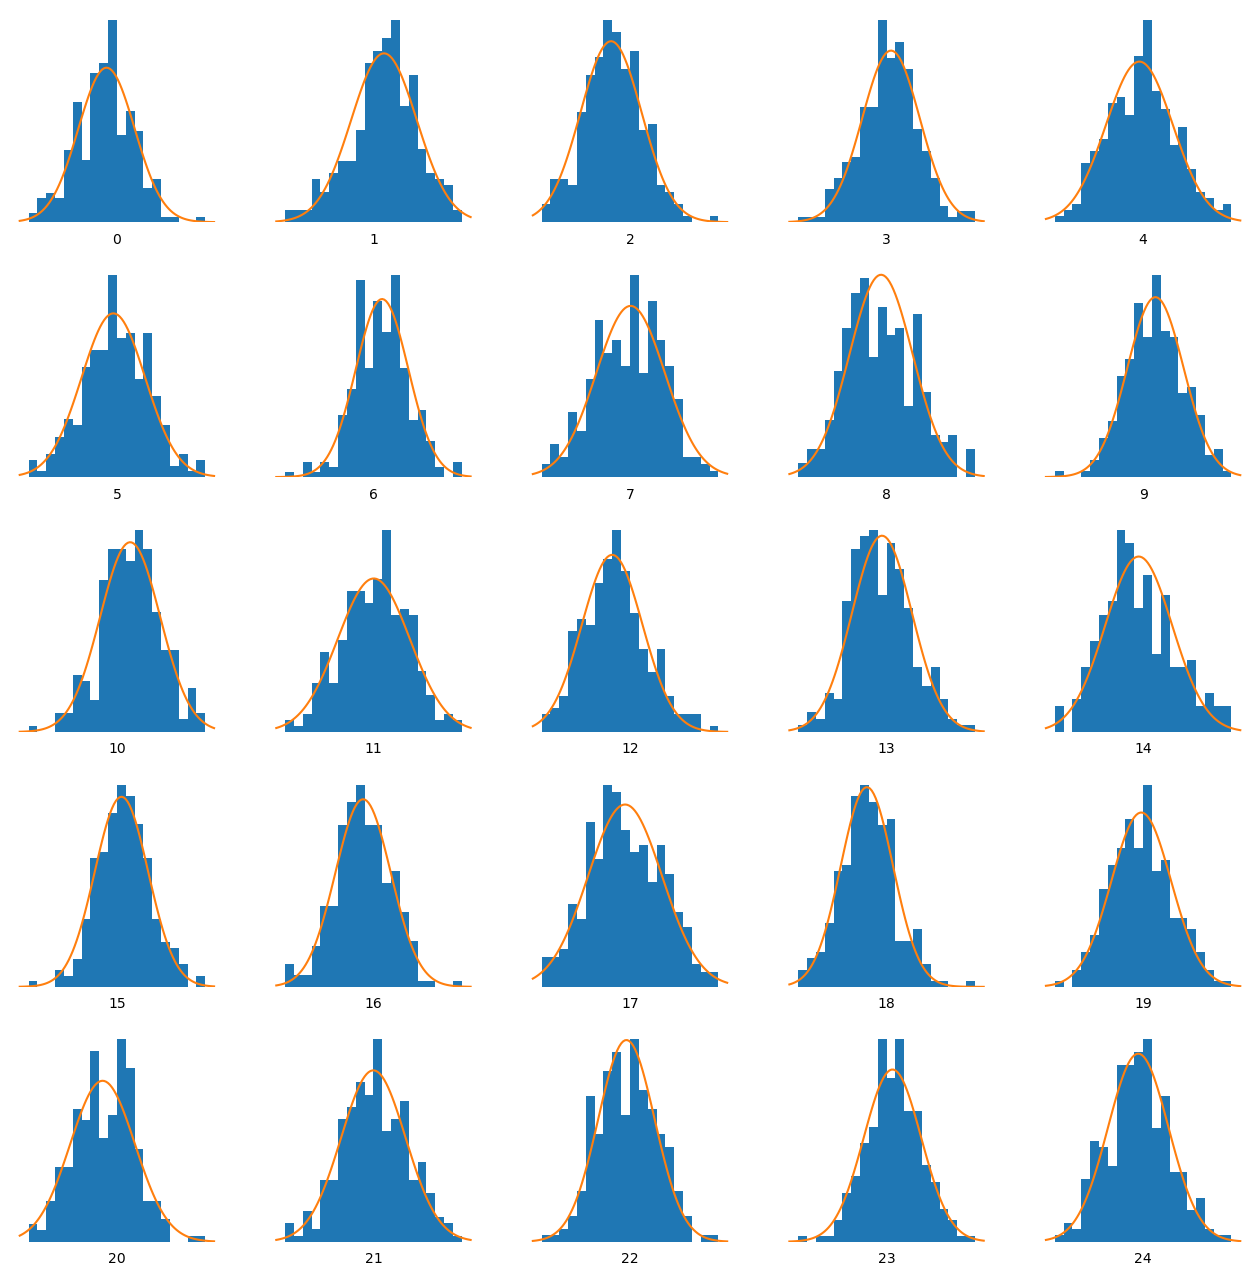

In [99]:
fig = plt.figure(figsize=(figsize, figsize))
from torch.distributions import Normal

# Define the mean and standard deviation of the normal distribution
mean = 0.0
std_dev = 1.0

# Create the normal distribution
normal_dist = Normal(loc=mean, scale=std_dev)

# Evaluate the PDF
for i in range(25):
    ax = fig.add_subplot(5, 5, i + 1)
    ax.hist(z[:, i].numpy(), 20, density=True)
    ax.axis("off")
    ax.text(0.5, -0.1, str(i), fontsize=10, ha="center", transform=ax.transAxes)
    xmin, xmax = plt.xlim()
    x = torch.linspace(xmin, xmax, 100)
    p = normal_dist.log_prob(x).exp()
    # Plot the normal distribution curve
    plt.plot(x, p)

